In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns

from nba_utils import draw_3pt_piechart,plot_shot_chart

from IPython.display import display, HTML
from IPython.core.magic import register_cell_magic, register_line_cell_magic, register_line_magic
from matplotlib import pyplot as plt
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import array, col, count, mean, sum, udf, when
from pyspark.sql.types import DoubleType, IntegerType, StringType, Row
from pyspark.sql.functions import sum, col, udf
from pyspark.sql import SparkSession

import warnings
warnings.filterwarnings("ignore")

sns.set_style("white")
sns.set_color_codes()

In [2]:
# set default plot settings
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['font.size'] = 9
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 18

# for export purposes only
display(HTML(''))
update_title = 'document.title = "Using Python and Apache Spark to Analyze the NBA and the 3-point Shot";'
HTML(''.format(update_title))
    

# Season Totals: The Rise of the 3-Point Shot

In [3]:
spark = SparkSession.builder.appName("MySparkApp").config("spark.some.config.option", "config-value").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/29 22:26:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


we read in the season total stats for every player since the 1979-80 season into a Spark DataFrame using PySpark

In [4]:
df = spark.read.option('header','true')\
          .option('inferSchema','true')\
          .csv('data/season_totals.csv')

In [5]:
# Rename Columns

# Define a mapping of old column names to new column names
column_mapping = {
    '_c0': 'index',
    'fg': 'field_goals',
    'fga': 'field_goal_attempts',
    'fg_pct': 'field_goal_percentage',
    'fg3': 'three_point_field_goals',
    'fg3a': 'three_point_field_goal_attempts',
    'fg3_pct': 'three_point_field_goal_percentage',
    'fg2': 'two_point_field_goals',
    'fg2a': 'two_point_field_goal_attempts',
    'fg2_pct': 'two_point_field_goal_percentage',
    'efg_pct': 'effective_field_goal_percentage',
    'ft': 'free_throws',
    'fta': 'free_throw_attempts',
    'ft_pct': 'free_throw_percentage',
    'orb': 'offensive_rebounds',
    'drb': 'defensive_rebounds',
    'trb': 'total_rebounds',
    'ast': 'assists',
    'stl': 'steals',
    'blk': 'blocks',
    'tov': 'turnovers',
    'pf': 'personal_fouls',
    'pts': 'points',
    'yr': 'year',
    'mp': 'minutes_played',
    'gs': 'games_started',
    'g' : 'games_played',
    'pos' : 'position'
}

# Rename all the columns in the DataFrame using the mapping
for old_col, new_col in column_mapping.items():
    df = df.withColumnRenamed(old_col, new_col)

# # Display the updated DataFrame
# df.show()

df.cache() # cache the result as we will refer back to this dataframe

23/07/29 22:26:46 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


DataFrame[index: int, player: string, position: string, age: int, team_id: string, games_played: int, games_started: int, minutes_played: int, field_goals: int, field_goal_attempts: int, field_goal_percentage: double, three_point_field_goals: int, three_point_field_goal_attempts: int, three_point_field_goal_percentage: double, two_point_field_goals: int, two_point_field_goal_attempts: int, two_point_field_goal_percentage: double, effective_field_goal_percentage: double, free_throws: int, free_throw_attempts: int, free_throw_percentage: double, offensive_rebounds: int, defensive_rebounds: int, total_rebounds: int, assists: int, steals: int, blocks: int, turnovers: int, personal_fouls: int, points: int, year: int]

Explaination about the different Positions in the game of Basketball

Point Guard (PG): The point guard is often considered the leader on the court and is responsible for directing the team's offense, setting up plays, and distributing the ball to teammates. They are usually good ball handlers and playmakers.

Shooting Guard (SG): The shooting guard is known for their scoring ability, especially shooting from long range. They are often tasked with shooting three-pointers and driving to the basket for points.

Small Forward (SF): The small forward is a versatile player who can both score and play strong defense. They are often seen as all-around players and can contribute in various aspects of the game.

Power Forward (PF): The power forward is typically a strong player who plays close to the basket. They are responsible for rebounding, scoring in the paint, and playing tough defense.

Center (C): The center is usually the tallest player on the team and plays close to the basket. They are key rebounders, shot blockers, and scorers in the paint.

In [6]:
# We can also view the column names of our DataFrame:
print(df.columns)

['index', 'player', 'position', 'age', 'team_id', 'games_played', 'games_started', 'minutes_played', 'field_goals', 'field_goal_attempts', 'field_goal_percentage', 'three_point_field_goals', 'three_point_field_goal_attempts', 'three_point_field_goal_percentage', 'two_point_field_goals', 'two_point_field_goal_attempts', 'two_point_field_goal_percentage', 'effective_field_goal_percentage', 'free_throws', 'free_throw_attempts', 'free_throw_percentage', 'offensive_rebounds', 'defensive_rebounds', 'total_rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'personal_fouls', 'points', 'year']


Using our DataFrame, we can view the top 10 players, sorted by number of points in an individual season. Notice we use the toPandas function to retrieve our results. The corresponding result looks cleaner for display than when using the take function.  

In [7]:
df.orderBy('points',ascending = False).limit(10).toPandas()[['year','player','age', 'position', 'points','three_point_field_goals']]

23/07/29 22:26:46 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , player, pos, age, team_id, g, gs, mp, fg, fga, fg_pct, fg3, fg3a, fg3_pct, fg2, fg2a, fg2_pct, efg_pct, ft, fta, ft_pct, orb, drb, trb, ast, stl, blk, tov, pf, pts, yr
 Schema: _c0, player, pos, age, team_id, g, gs, mp, fg, fga, fg_pct, fg3, fg3a, fg3_pct, fg2, fg2a, fg2_pct, efg_pct, ft, fta, ft_pct, orb, drb, trb, ast, stl, blk, tov, pf, pts, yr
Expected: _c0 but found: 
CSV file: file:///Users/huiyingooi/Desktop/projects/NBA-Analytics-Spark/data/season_totals.csv


,year,player,age,position,points,three_point_field_goals
0,1987,"Jordan,Michael",23,SG,3041,12
1,1988,"Jordan,Michael",24,SG,2868,7
2,2006,"Bryant,Kobe",27,SG,2832,180
3,1990,"Jordan,Michael",26,SG,2753,92
4,1989,"Jordan,Michael",25,SG,2633,27
5,2014,"Durant,Kevin",25,SF,2593,192
6,1980,"Gervin,George",27,SG,2585,32
7,1991,"Jordan,Michael",27,SG,2580,29
8,1982,"Gervin,George",29,SG,2551,10
9,1993,"Jordan,Michael",29,SG,2541,81


Next, we can analyze the number of 3 point attempts taken each season computing the average attempts per 36 minutes for each season.

The per 36 minutes metric provides an estimate of a given player’s stats projected to 36 minutes, an interval corresponding to an approximate full NBA game with adequate rest, while also allowing comparison across players that play different numbers of minutes.

In [8]:
# 3 point attempts / 36 minute
fga_py = df.groupBy('year')\
           .agg({'minutes_played' : 'sum', 'three_point_field_goal_attempts' : 'sum'})\
           .select(col('year'), (36*col('sum(three_point_field_goal_attempts)')/col('sum(minutes_played)')).alias('three_point_field_goal_attempts_per_36_minutes'))\
           .orderBy('year')

Text(1998.5, 2.4, 'NBA moved back\n3-point line')

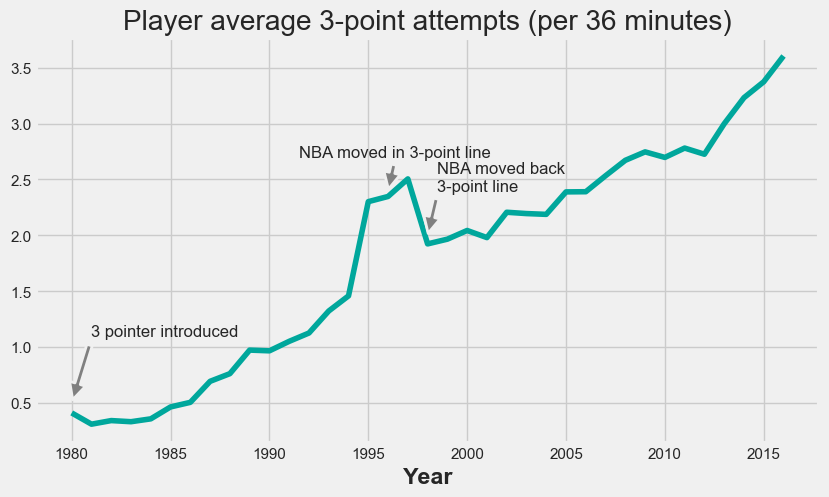

In [9]:
from matplotlib import pyplot as plt 
import seaborn as sns
plt.style.use('fivethirtyeight')

_df = fga_py.toPandas()
plt.plot(_df.year,_df.three_point_field_goal_attempts_per_36_minutes, color = '#00a79c')
plt.xlabel('Year')
_=plt.title('Player average 3-point attempts (per 36 minutes)')
plt.annotate('3 pointer introduced', xy=(1980, .5), xytext=(1981, 1.1), fontsize = 12,
            arrowprops=dict(facecolor='grey', shrink=0.05, linewidth = 2))
plt.annotate('NBA moved in 3-point line', xy=(1996, 2.4), xytext=(1991.5, 2.7), fontsize = 12,
            arrowprops=dict(facecolor='grey', shrink=0.05, linewidth = 2))
plt.annotate('NBA moved back\n3-point line', xy=(1998, 2.), xytext=(1998.5, 2.4), fontsize = 12, arrowprops=dict(facecolor='grey', shrink=0.05, linewidth = 2))

We can see a steady rise in the number of 3 point attempts since the shot's introduction in the 1979-80 season, along with a blip in number of attempts during the period in the mid 90's when the NBA moved the line in a few feet.


# Building a linear regression model


We can fit a linear regression model to this curve to model the number of shot attempts for the next 5 years. Of course, this assumes a linear nature of the rate of increase of attempts and is likely a naive assumption.

Firstly, we must transform our data using the VectorAssembler function to a single column where each row of the DataFrame contains a feature vector. This is a requirement for the linear regression API in MLlib. We first build the transformer using our single variable `yr` and transform our season total data using the transformer function.

In [10]:
# train the model
from pyspark.ml.feature import VectorAssembler
#  This class will be used to assemble the input features into a single vector column.

t = VectorAssembler(inputCols=['year'], outputCol = 'features')
# The VectorAssembler is a feature transformer that takes multiple columns from a DataFrame and assembles them into 
# a single vector column. In this case, it is used to assemble the column 'yr' (which represents the year) into a vector 
# column named 'features'.
training = t.transform(fga_py)\
            .withColumn('year',fga_py.year)\
            .withColumn('label',fga_py.three_point_field_goal_attempts_per_36_minutes)
# Add new columns: After transforming the DataFrame, the code adds two new columns to the DataFrame

training.toPandas().head()

,year,three_point_field_goal_attempts_per_36_minutes,features,label
0,1980,0.410089,[1980.0],0.410089
1,1981,0.309376,[1981.0],0.309376
2,1982,0.341511,[1982.0],0.341511
3,1983,0.331479,[1983.0],0.331479
4,1984,0.357110,[1984.0],0.357110


In [11]:
lr = LinearRegression(maxIter=10)
model = lr.fit(training)
     

23/07/29 22:26:49 WARN Instrumentation: [1bd7c190] regParam is zero, which might cause numerical instability and overfitting.
23/07/29 22:26:49 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/07/29 22:26:49 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
23/07/29 22:26:49 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Next, we want to apply our trained model object model to our original training set along with 5 years of future data. Containing this time period, we build a new DataFrame, transform it to include a feature vector, and then apply our model to make a prediction.

In [12]:
# apply model for the 1979-80 season thru 2020-21 season
training_yrs = training.select('year').rdd.map(lambda x: x[0]).collect()
training_y = training.select('three_point_field_goal_attempts_per_36_minutes').rdd.map(lambda x: x[0]).collect()
prediction_yrs = [2017, 2018, 2019, 2020, 2021]
all_yrs = training_yrs + prediction_yrs

# built testing DataFrame
test_rdd = spark.sparkContext.parallelize(all_yrs)
row = Row('year')
all_years_features = t.transform(test_rdd.map(row).toDF())
# A function Row() is used to convert each element of the RDD into a Row object with a single field 'year'.

# apply linear regression model
df_results = model.transform(all_years_features).toPandas()
     
# The model uses the feature values (years) to generate the corresponding predictions for the target variable (fg3a_p36m)


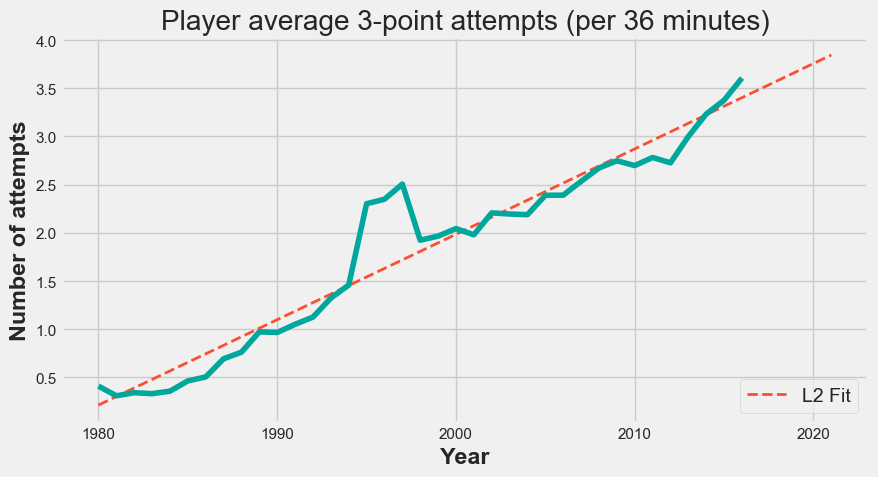

In [13]:
plt.plot(df_results.year,df_results.prediction, linewidth = 2, linestyle = '--',color = '#fc4f30', label = 'L2 Fit')
plt.plot(training_yrs, training_y, color = '#00a79c', label = None)
plt.xlabel('Year')
plt.ylabel('Number of attempts')
plt.legend(loc = 4)
_=plt.title('Player average 3-point attempts (per 36 minutes)')
plt.tight_layout()
plt.savefig('results/model_prediction.png')
     

# Shot chart data

In addition to season total data, we process and analyze NBA shot charts to view the impact the 3-point revolution has had on shot selection. The shot chart data was acquired from nbasavant.com, which sources it's data from NBA.com and ESPN.

The shot chart data contains xy coordinates of field goal attempts for individual players, game date, time of shot, shot distance, a shot made flag, and other fields. We have compiled all individual seasons where a player attempted at least 1000 field goals attempts from the 2010-11 through the 2015-16 season.

As before we can read in the CSV data into a Spark DataFrame.

In [14]:
# reset style for pretty shot charts
plt.style.use('default')
sns.set_style("white")

df = spark.read\
          .option('header', 'true')\
          .option('inferSchema', 'true')\
          .csv('data/shot_charts_top_10/1000_plus_shot_charts_2011_2016.csv')
df.cache() # optimizes performance for later calls to this dataframe
print(df.count())
df.orderBy('game_date').limit(10).toPandas()[['yr','name','game_date','shot_distance','x','y','shot_made_flag']]
     

23/07/29 22:26:53 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , yr, name, team_name, game_date, season, espn_player_id, team_id, espn_game_id, period, minutes_remaining, seconds_remaining, shot_made_flag, action_type, shot_type, shot_distance, opponent, x, y, dribbles, touch_time, defender_name, defender_distance, shot_clock
 Schema: _c0, yr, name, team_name, game_date, season, espn_player_id, team_id, espn_game_id, period, minutes_remaining, seconds_remaining, shot_made_flag, action_type, shot_type, shot_distance, opponent, x, y, dribbles, touch_time, defender_name, defender_distance, shot_clock
Expected: _c0 but found: 
CSV file: file:///Users/huiyingooi/Desktop/projects/NBA-Analytics-Spark/data/shot_charts_top_10/1000_plus_shot_charts_2011_2016.csv


243719


,yr,name,game_date,shot_distance,x,y,shot_made_flag
0,2011,Paul Pierce,2010-10-26,0,-2,-5,1
1,2011,Luis Scola,2010-10-26,3,0,31,1
2,2011,LaMarcus Aldridge,2010-10-26,21,39,211,0
3,2011,Luis Scola,2010-10-26,9,99,9,0
4,2011,Paul Pierce,2010-10-26,24,159,186,0
5,2011,Luis Scola,2010-10-26,6,-59,20,1
6,2011,Paul Pierce,2010-10-26,24,198,148,1
7,2011,Luis Scola,2010-10-26,16,4,165,0
8,2011,Paul Pierce,2010-10-26,25,67,246,1
9,2011,Luis Scola,2010-10-26,8,89,9,1


We can query an individual player and season and visualize their shots locations. We utilize code based on Savvas Tjortjoglou's wonderful example.

As an example, we visualize Steph Curry's 2015-2016 historic shooting season using a hexbin plot.


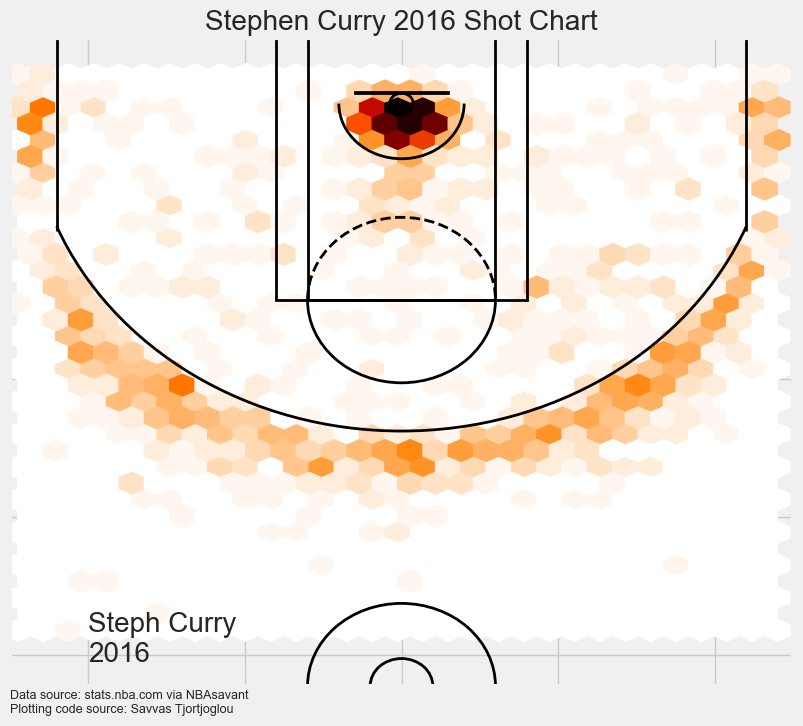

In [15]:
# TODO


import seaborn as sns
import matplotlib.pyplot as plt
from nba_utils import plot_shot_chart

player = 'Stephen Curry'
yr = '2016'
df_steph = df.filter('''name == "{player}"
                        and yr == {yr}
                        and y < 400'''.format(player=player, yr=yr))
x = np.array([v[0] for v in df_steph.select('x').collect()])
y = np.array([v[0] for v in df_steph.select('y').collect()])

# Set font style (optional)
plt.rcParams['font.serif'] = 'Ubuntu'
plt.style.use('fivethirtyeight')

# Call the custom function
p = plot_shot_chart(x=x, y=y, kind='hex', gridsize=30,
                    norm=None, label='Steph Curry\n2016',
                    title='Stephen Curry 2016 Shot Chart')

# Save the plot
p.savefig('results/steph_curry_2016_shotchart.png')
